### explore the data model, or the likelihood use deterministic plankton model (with built-in in DifferentialEquation.jl)

In [1]:
using DifferentialEquations, PyPlot, Distributions, LaTeXStrings, Statistics

In [2]:
simulate(u,p,t) = p[1]*(1+sin(p[2]*t))*u - p[3]*u^2

simulate (generic function with 1 method)

In [3]:
function loglike(theta,obs)
    # step 1: run the model given the parameters to get state
    tobs = obs[:,1]
    yobs = obs[:,2]
    u₀ = 2.5;
    tspan = (0.0, maximum(tobs))
    p = [theta[1], 2*π/365, theta[2]]
    prob = ODEProblem(simulate,u₀,tspan,p)
    sol = solve(prob,reltol=1e-6,saveat=15.0)
    xhat = sol.u
    # step 2: compute the likelihood (compare state to observations)
    L = -sum((yobs .- xhat).^2)
    return L
end

loglike (generic function with 1 method)

In [4]:
T = 365*4
p = [0.25, 2*π/365, 0.1];
u₀ = 2.5;
tobs = collect(0:15:T)
tspan = (0.0, maximum(tobs))
prob = ODEProblem(simulate,u₀,tspan,p)
sol = solve(prob,reltol=1e-6,saveat=15.0)
yobs = sol.u .+ 0.3 .* rand(Normal(),size(sol.u))

obs = hcat(tobs,yobs);

### Generate Synthetic Observations
- make up some synthetic (~biweekly) observations
- simulate P, extract every 15th day, add some white noise

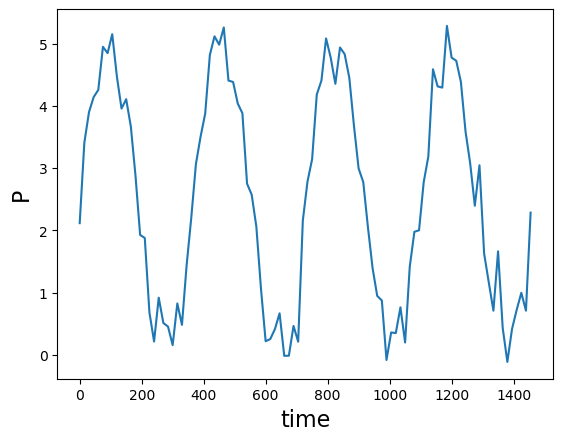

In [5]:
fig, ax = PyPlot.subplots()
ax.plot(tobs,yobs)
ax.set_ylabel("P",fontsize=16)
ax.set_xlabel("time",fontsize=16);

### Likelihood
- spot likelihood value: how probable is the set of parameters?

In [6]:
# specify the parameters
theta = [0.2, 0.15] # γ,om, λ

# compute likelihood
L = loglike(theta,obs)

-211.0152778050618

### Likelihood Profiles
profile each parameter separately, fix other param at "true" value

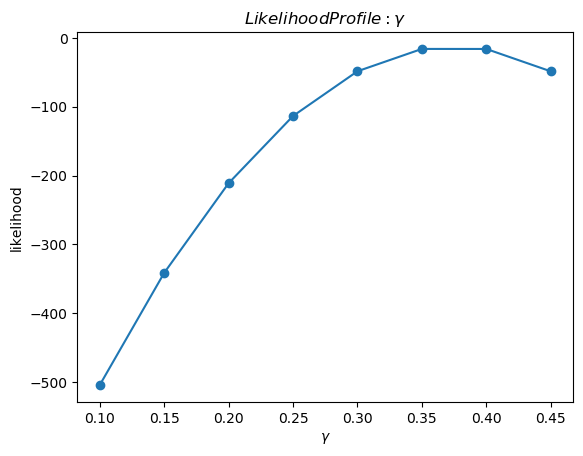

In [7]:
# γ
theta = [0.2, 0.15] # γ,om, λ
gamma_grid = collect(0.1:0.05:0.45)
Lγ = zeros(size(gamma_grid))
for i in 1:size(gamma_grid,1)
    theta[1] = gamma_grid[i]
    Lγ[i] = loglike(theta, obs)
end

fig, ax = plt.subplots()
ax.plot(gamma_grid, Lγ, marker="o")
ax.set(title=L"Likelihood Profile: \gamma", xlabel=L"\gamma", ylabel="likelihood");

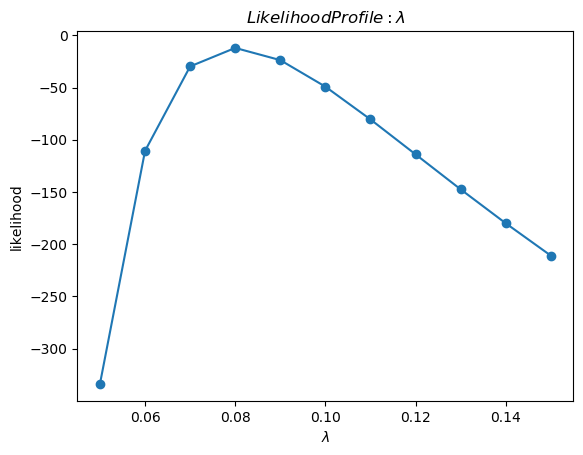

In [8]:
# λ
theta = [0.2, 0.15] # γ,om, λ
lambda_grid = collect(0.05:0.01:0.15)
Lλ = zeros(size(lambda_grid))
for i in 1:size(lambda_grid,1)
    theta[2] = lambda_grid[i]
    Lλ[i] = loglike(theta, obs)
end

fig, ax = plt.subplots()
ax.plot(lambda_grid, Lλ, marker="o")
ax.set(title=L"Likelihood Profile: \lambda", xlabel=L"\lambda", ylabel="likelihood");

In [9]:
# 2D likelihood
theta = [0.2, 0.15] # γ,om, λ
gamma_grid = collect(0.2:0.01:0.3)
lambda_grid = collect(0.08:0.005:0.12)

Lacc = zeros(size(gamma_grid,1),size(lambda_grid,1));
for i in 1:size(gamma_grid,1)
    for j in 1:size(lambda_grid,1)
        theta[1] = gamma_grid[i]
        theta[2] = lambda_grid[j]
        Lacc[i,j] = loglike(theta, obs)
    end
end

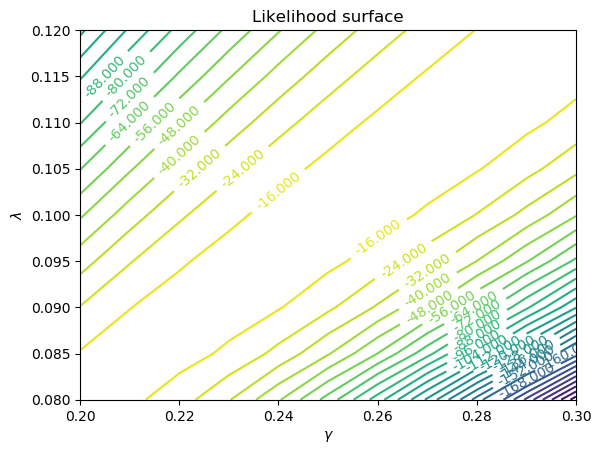

In [10]:
fig, ax = plt.subplots()
cs = ax.contour(gamma_grid, lambda_grid, reverse(rotl90(Lacc),dims=1), levels=30)
ax.clabel(cs, fontsize=10)
ax.set(title="Likelihood surface", xlabel=L"\gamma", ylabel=L"\lambda");

In [11]:
using Optim

In [25]:
function loglike_neg(theta)
    u₀ = 2.5;
    tspan = (0.0, T)
    p = [theta[1], 2*π/365, theta[2]]
    prob = ODEProblem(simulate,u₀,tspan,p)
    xhat = solve(prob,reltol=1e-6,saveat=15.0).u
    L = sum((obs[:,2] .- xhat).^2)
    return L
end

loglike_neg (generic function with 1 method)

In [59]:
result = optimize(loglike_neg, [0.25,0.1])

 * Status: success

 * Candidate solution
    Minimizer: [2.64e-01, 1.05e-01]
    Minimum:   1.152079e+01

 * Found with
    Algorithm:     Nelder-Mead
    Initial Point: [2.50e-01, 1.00e-01]

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    33
    f(x) calls:    69
